# Finite Element Methods for 1D Poisson equation

In [9]:
import numpy as np; 
import matplotlib.pyplot as plt;

Consider the Poisson equation on the interval $\Omega = (0,1)$

\begin{equation} -u''(x) = f(x) \quad \text{in } \Omega,  \qquad u = 0 \quad\text{on } \partial \Omega\end{equation}

testing the equation by a function $v\in V$, and integrating over $\Omega$ we obtain

\begin{equation}
-\int_{\Omega}u'' \,v = \int_{\Omega}f\, v
\end{equation}

We now integrate by parts obtaining the weak formulation of the Poisson problem:  Find $u \in V$ such that

\begin{equation}
a(u,v)= (f,v),\qquad \text{where}\quad a(u,v):= \int_{\Omega}u'\,v'\quad \text{and}\quad (f,v):=\int_{\Omega}f\,v. 
\end{equation}

We will discretize this formulation in order to derive a finite element method.

### Galerkin scheme

We begin by discretizing the space. Consider a finite dimensional space $V_{h}\subset V$. Then, the Galerkin scheme reads as:
Find $u_{h}\in V_{h}$ such that

\begin{equation}
a(u_{h},v) = (f,v),\qquad \text{for all } v\in V_{h}.
\end{equation}

Observe that now we have finite dimesional system of equations, where the unknows are the coefficients of $u_h$ in terms of a basis of the space $V_h$. We still do not have a method, we need to choose the the finite dimensional (o finite element space) $V_{h}$. 

We begin the presentation with the classical finite element space of continuous piecewise linear polynomials.

Define first a sequence of points $0=x_0<x_1<...<x_n =1$, which partitioned the domain $\Omega = (0,1)$ into subintervals $K_{j} = (x_{j}, x_{j+1})$, for $j=0,...n-1$ and let

\begin{equation}
h_{j} = |K_{j}| = x_{j+1} - x_j\quad \text{for } j=0,...,n-1, \qquad \text{and }\quad h =max_{0\leq j\leq n-1} h_{j} 
\end{equation}

Then, let $\mathcal{T}_{h} = \{ K\}_{h}$ the collection of this subintervals.

We now define the continuous piecewise linear finite element space

\begin{equation}
V_{h} = \{ v\in C_0(\Omega): v|_{K}\in \mathbb{P}^{1}(K)\,\forall K\in \mathcal{T}_{h} \}
\end{equation}

#### Example:

Consider a uniform partition of the domain $(0,1)$ into $n = 5$ subintervals. We present the plot of a function in the space $V_{h}$.

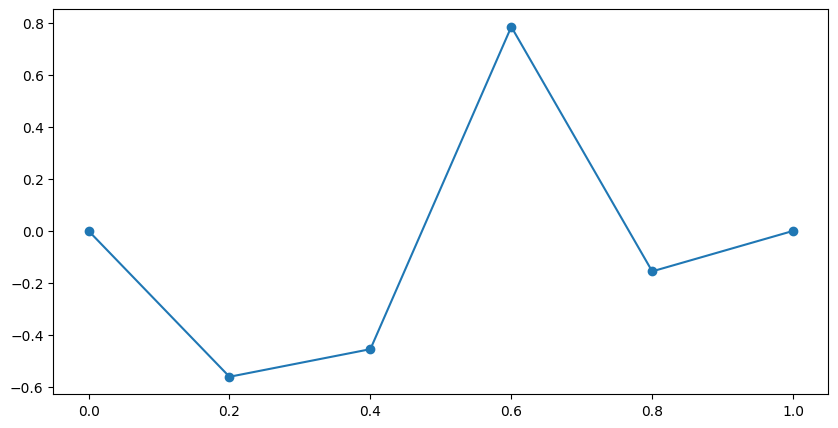

In [10]:
x = np.linspace(0,1,num = 6);
u = np.hstack([0,-1+2*np.random.rand(4),0]);
plt.figure(figsize=(10,5)); plt.plot(x,u,'o-'); plt.show();

### Basis of $V_{h}$.

As it was mentioned early, in order to transform the problem the problem to system of equations we need to decide a basis for the space $V_{h}$. The standard basis is known as the "hat functions", defined by

\begin{equation}
\phi_{j}\in V_{h}: \qquad \phi_{j}(x_i) = \delta_{i j} \quad \text{for } i,j = 0,...,n
\end{equation}

Note that the support of the basis funcions is $K_{j-1}\cup K_{j}$.

For the previous example, we plot the "hat functions". Observe that $\phi_0 = \phi_6 = 0$.

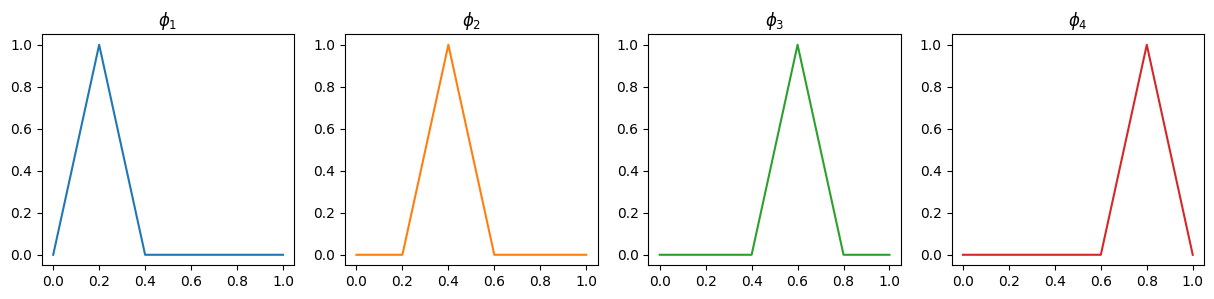

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(141); plt.plot(x,np.array([0,1,0,0,0,0]),'C0'); plt.title('$\phi_1$'); 
plt.subplot(142); plt.plot(x,np.array([0,0,1,0,0,0]),'C1'); plt.title('$\phi_2$');
plt.subplot(143); plt.plot(x,np.array([0,0,0,1,0,0]),'C2'); plt.title('$\phi_3$');
plt.subplot(144); plt.plot(x,np.array([0,0,0,0,1,0]),'C3'); plt.title('$\phi_4$');

We represent any function $v\in V_{h}$ in the basis by

\begin{equation}
v(x) = \sum_{j=0}^{n} c_{j} \phi_{j}(x),\quad x\in\Omega.
\end{equation}

Hence, the Galerkin scheme is reduced to the following linear system: Find $u_h = \sum_{j=0}^{n} c_{j} \phi_{j}\in V_h$ such that $

\begin{equation}
a(u_h,\,\phi_{i}) = (f,\,\phi_{i})\quad \text{for }i=0,...,n
\end{equation}

it a linear system $Ac = b$, where
\begin{equation}
A_{i,j} = a(\phi_{j},\,\phi_{i}),\qquad b_{i} = (f,\,\phi_{i}),\quad \text{for }i,j = 0,..,n.
\end{equation}
    


### Uniform grid
Observe that, in the case $h_{j} = h$ for all $j = 0,...,n-1$, we have that

\begin{equation}
a(\phi_{j}, \,\phi_{i}) = \int_{\Omega} \phi_{j}'\,\phi_{i}' = \left\{ \begin{array}{cl} \frac{2}{h} & \text{if } i=j\\\frac{-1}{h}& \text{if } i=j-1 \text{ or } i = j+1\\
0& \text{otherwise}\end{array}\right.
\end{equation}

In [12]:
def ijvAssembling(row, col, AK): # First element example!!! - dof = [0 1] = row = col
    prod = [(x,y) for x in row for y in col]; # [(0,0), (0,1), (1,0), (1,1)]
    i = [x for (x,y) in prod] # [0,0,1,1]
    j = [y for (x,y) in prod] # [0,1,0,1]
    v = np.reshape(AK, (1,AK.size)) # [A^1_11 (0), A^1_12 (0), A^1_21 (0), A^1_22]
    return i, j, v

In [13]:
# 1D FEM for Poisson equation
# -u'' = f in (0,1), u(0) = u(1) = 0
import scipy.sparse as sps
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad

def poisson_1d_FEM_solver(l, plot_sol=False, compute_errors=False):

    # Input
    xi = 0; xf = 1;
    f = lambda x: np.sin(2*np.pi*x)
    # Exact solution 
    u = lambda x: 1/(2*np.pi)**2*np.sin(2*np.pi*x);
    Du = lambda x: 1/(2*np.pi)*np.cos(2*np.pi*x);

    # Triangulation / Mesh
    n = 2**l;
    Coordinates = np.linspace(xi, xf, num = n+2); # cambiar para no uniforme
    NN = Coordinates.size; # number of coordinates 
    Elements = np.vstack([range(n+1), range(1,n+2)]).T;
    NE = Elements.shape[0];

    h = np.max([abs(Coordinates[j+1] - Coordinates[j]) for j in range(n)])

    NAK = 4
    row = np.zeros(NE*NAK)
    col = np.zeros(NE*NAK)
    Avalues = np.zeros(NE*NAK)

    # Load vector
    b = np.zeros(NN);

    for j in range(NE): # j = 0 -> Element [0,1] -> Coordinates are 0.0 and 0.2
        dof = Elements[j,:]
        K = Coordinates[dof]
        
        # Local stiffness matrix 
        #AK = np.zeros((2,2), dtype = np.float64) # AK = integral(phi_i'*phi_j', I_j) = (1/h_j)[1,-1;-1,1] row 2  A_i,i = (phi_i, phi_i)
        AK = (1.0/h)*np.array([[1,-1],[-1,1]]) # Change for non uniform mesh 
        
        # Assembling stiffness matrix
        iK, jK, vK = ijvAssembling(dof, dof, AK) # dof = [0 1]
        row[NAK*j:(NAK*(j+1))] = iK;
        col[NAK*j:(NAK*(j+1))] = jK;
        Avalues[NAK*j:(NAK*(j+1))] = vK;
        
        # Local load vector
        bK = np.zeros(2);
        phi = lambda x: [(K[1]-x)/h, (x-K[0])/h]
        for i in range(2):
            bK[i] = quad(lambda x: f(x)*phi(x)[i], K[0], K[1])[0]
        # Assembling load vector
        b[dof] = b[dof] + bK
    # end for

    A = sps.coo_matrix(( Avalues,(row, col)), (n+2,n+2), dtype = np.float64)

    # Solve linear system
    uh = np.zeros(n+2);
    # slow (but simple) slicing
    Free = range(1,n+1);
    AFree = A.tocsc()[Free, :][:, Free]
    bFree = b[Free]
    uh[Free] = spsolve(AFree, bFree)

    if plot_sol:
        x = np.linspace(0,1,100);
        plt.plot(x, u(x), '--C1');
        plt.plot(Coordinates,uh, 'C0'); 
        plt.legend(['exact', 'FEM - P1'])
        plt.show();

    if compute_errors:
        # Compute L^2 and H^1 errors 
        # ErrorL2 = || u - uh ||_L2 
        # ErrorH1 = || Du - Duh ||_L2

        EL2 = 0; EH1 = 0;
        for j in range(NE):
            dof = Elements[j,:]
            K = Coordinates[dof]
            
            phi = lambda x: [(K[1]-x)/h, (x-K[0])/h]
            uhfun = lambda x: np.dot(uh[dof], phi(x))
            efun = lambda x: abs(u(x) - uhfun(x))
            EL2 += quad(lambda x: efun(x)**2, K[0], K[1])[0]
            
            Dphi = [-1/h, 1/h];
            Duh = np.dot(uh[dof], Dphi);
            Defun = lambda x: abs(Du(x) - Duh);
            EH1 += quad(lambda x: Defun(x)**2, K[0], K[1])[0]
        # end for
        EL2 = np.sqrt(EL2)
        EH1 = np.sqrt(EH1)
        return (EL2, EH1)

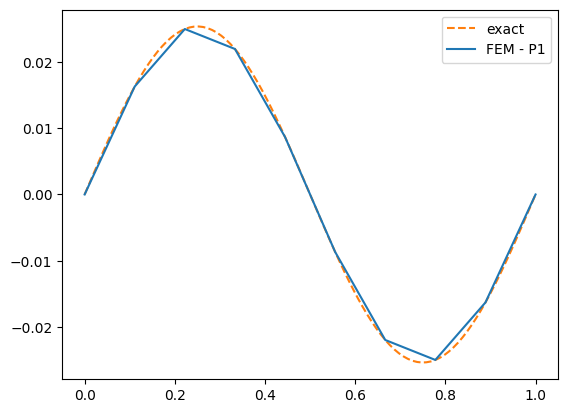

In [14]:
poisson_1d_FEM_solver(l=3, plot_sol=True, compute_errors=False)

### Convergence

In [15]:
# Estimated order of convergence
n_exp = 5
h = [1/(2**l+1) for l in range(1,n_exp+1)]
rEL2 = ['-']; rEH1 = ['-']
EL2v = np.zeros(n_exp); EH1v = np.zeros(n_exp)

for l in range(n_exp):
    EL2, EH1 = poisson_1d_FEM_solver(l, plot_sol=False, compute_errors=True)
    EL2v[l] = EL2
    EH1v[l] = EH1

for j in range(n_exp-1):
    rEL2.append(np.log(EL2v[j+1]/EL2v[j])/ np.log(h[j+1]/h[j]))
    rEH1.append(np.log(EH1v[j+1]/EH1v[j])/ np.log(h[j+1]/h[j]))

In [16]:
import pandas as pd

df = pd.DataFrame({'n':[f'2^{l}' for l in range(n_exp)],
              'h':[f'1/(2^{l}+1)' for l in range(n_exp)],
              r'Error L^2':EL2v,
              r'Order L^2':rEL2,
              r'Error H^1':EH1v,
              r'Order H^1':rEH1
              })
display(df)

,n,h,Error L^2,Order L^2,Error H^1,Order H^1
0,2^0,1/(2^0+1),0.017911,-,0.112540,-
1,2^1,1/(2^1+1),0.006512,1.980824,0.063271,1.127345
2,2^2,1/(2^2+1),0.002494,1.632554,0.039766,0.790091
3,2^3,1/(2^3+1),0.000788,1.810787,0.022497,0.895672
4,2^4,1/(2^4+1),0.000223,1.906109,0.011980,0.950026
